<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW3_Classification_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Кака всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [1]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [3]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration


    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        n_samples, n_features = X.shape
        self.loss_history = []

        self.w = np.zeros(n_features) if self.w0 is None else self.w0.copy()

        for _ in range(self.max_iter):
            if self.gd_type == 'full':
                gradient = self.calc_gradient(X, y)
            elif self.gd_type == 'stochastic':
                rand_index = np.random.randint(0, n_samples)
                X_i = X[rand_index, :].reshape(1, -1)
                y_i = y[rand_index]
                gradient = self.calc_gradient(X_i, y_i)
            else:
                raise ValueError("gd_type must be 'full' or 'stochastic'")

            new_w = self.w - self.eta * gradient

            # Calculate loss and check convergence
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            if np.linalg.norm(new_w - self.w) < self.tolerance:
                break

            self.w = new_w

        return self


    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        proba = self.sigmoid(X @ self.w)
        return np.column_stack((1 - proba, proba))


    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        # Вообще было бы неплохо задать параметр threshold, но будем считать дефолтные 0.5 для порога 
        return (self.sigmoid(X @ self.w) >= 0.5).astype(int)

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        m = X.shape[0]
        preds = self.sigmoid(X @ self.w)
        gradient = (1 / m) * (X.T @ (preds - y))
        return gradient

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        m = X.shape[0]
        preds = self.sigmoid(X @ self.w)
        loss = -(1 / m) * (y @ np.log(preds) + (1 - y) @ np.log(1 - preds))
        return loss

Теперь проверим работу вашего класса на синтетических данных.

In [4]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

In [6]:
logreg = LogReg()

In [7]:
logreg = logreg.fit(X_train, y_train)

In [8]:
# Нас интересуют предикты класса 1, поэтому берем вторую колонку
preds_proba = logreg.predict_proba(X_test)[:, 1]

In [9]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

In [10]:
roc_auc = roc_auc_score(y_test, preds_proba)
fpr, tpr, _ = roc_curve(y_test, preds_proba)

In [11]:
precision, recall, _ = precision_recall_curve(y_test, preds_proba)
pr_auc = auc(recall, precision)

In [12]:
print(f"Значение ROC_AUC: {roc_auc:.4f}")
print(f"Значение PR_AUC: {roc_auc:.4f}")

Значение ROC_AUC: 0.8927
Значение PR_AUC: 0.8927


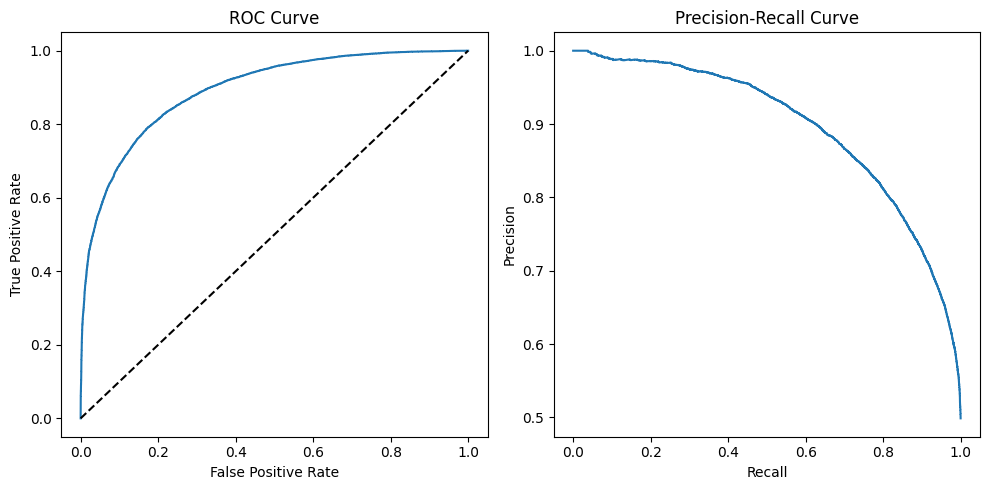

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # Диагональ
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

Что интересно, наша модель показала довольно неплохие результаты. Что касается численных значений, мы получили значения обеих метрик выше $0.9$ что является довольно хорошим показателем. Кривые ROC и PR подтверждают это. По ROC curve, чем ближе кривая для модели к верхнему левому углу - тем лучше. Для PR curve, чем ближе модель к правому верхнему углу - тем лучше. Мы получили довольно нелпохой результат в обоих случаях. Так что можно сказать, что модель работает корректно (скорее всего)

# **Часть 2. Отбор признаков (5 баллов)**

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные** \

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [107]:
PATH_TO_DATASET = "data/train.csv"

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
target = data.target.values
data.reset_index(inplace=True)
data.drop("id", axis=1, inplace=True)
data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [158]:
cat_columns = [col for col in data.columns if col.endswith('_cat')]
data_encoded = pd.get_dummies(data, columns=cat_columns, drop_first=False, dtype=int)

In [159]:
for col in cat_columns:
    if col in data_encoded.columns:
        data_encoded = data_encoded.drop(columns=[col])

In [160]:
num_features = data_encoded.shape[1]
num_features

227

In [198]:
X_train, X_test, y_train, y_test = train_test_split(data_encoded, target, test_size=0.2, random_state=124)

### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.


In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time
import warnings
warnings.filterwarnings("ignore")

In [162]:
# LogReg
start = time()
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_time = time() - start
logreg_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
print(f"ROC_AUC: {logreg_auc:.4f}, Время обучения: {logreg_time:.4f}s")

ROC_AUC: 0.6364, Время обучения: 12.6724s


In [42]:
import random
random.seed(52)
# В чате сказали, что можно обучить на сабсэмпле из 20к наблюдений
ids = random.sample(range(X_train.shape[0]), 20_000)

In [48]:
X_train_svm = X_train.iloc[ids]
y_train_svm = y_train[ids]

In [49]:
# SVM
start_time = time()
svm = SVC(probability=True)
svm.fit(X_train_svm, y_train_svm)
svm_time = time() - start_time
svm_auc = roc_auc_score(y_test, svm.predict_proba(X_test)[:, 1])
print(f"ROC_AUC: {svm_auc:.4f}, Время обучения: {svm_time:.4f}s")

ROC_AUC: 0.5325, Время обучения: 121.9935s


In [22]:
#  KNN
start_time = time()
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_time = time() - start_time
knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
print(f"ROC_AUC: {knn_auc:.4f}, Время обучения: {knn_time:.4f}s")

ROC_AUC: 0.5116, Время обучения: 0.6912s


In [50]:
from sklearn.model_selection import GridSearchCV

In [55]:
logreg_params = {
    'C': [0.1, 1, 10],
    'class_weight': [None, 'balanced']
}
logreg = LogisticRegression(max_iter=1000)
logreg_grid = GridSearchCV(logreg, logreg_params, cv=2, scoring='roc_auc')
logreg_grid.fit(X_train, y_train)
best_logreg = logreg_grid.best_estimator_
logreg_auc = roc_auc_score(y_test, best_logreg.predict_proba(X_test)[:, 1])

In [57]:
print(f"ROC_AUC лучшего эстиматора: {logreg_auc:.4f}")

ROC_AUC лучшего эстиматора: 0.6381


In [56]:
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly'],
    'class_weight': [None, 'balanced']
}
svm = SVC(probability=True, max_iter=1000)
svm_grid = GridSearchCV(svm, svm_params, cv=2, scoring='roc_auc')
svm_grid.fit(X_train_svm, y_train_svm)
best_svm = svm_grid.best_estimator_
svm_auc = roc_auc_score(y_test, best_svm.predict_proba(X_test)[:, 1])

In [58]:
print(f"ROC_AUC лучшего эстиматора: {svm_auc:.4f}")

ROC_AUC лучшего эстиматора: 0.5016


In [59]:
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=2, scoring='roc_auc')
knn_grid.fit(X_train, y_train)
best_knn = knn_grid.best_estimator_
knn_auc = roc_auc_score(y_test, best_knn.predict_proba(X_test)[:, 1])

In [60]:
print(f"ROC_AUC лучшего эстиматора: {knn_auc:.4f}")

ROC_AUC лучшего эстиматора: 0.5142


### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроеным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)

- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)




In [ ]:
start = time()
logreg_new = LogisticRegression()
logreg_new.fit(X_train, y_train)
weights = np.abs(logreg_new.coef_).flatten()
top_features_indices = np.argsort(weights)[-150:]
print(f"Время отбора: {time() - start:.4f}s")

Время отбора: 10.9453s


In [215]:
X_to_scale = []

for col_name in X_train.columns:
    if not ("cat" in col_name or "bin" in col_name):
        X_to_scale.append(col_name) 

In [227]:
len(X_to_scale)

26

In [216]:
X_train = X_train.reset_index()
X_train = X_train.drop("index", axis=1)

X_test = X_test.reset_index()
X_test = X_test.drop("index", axis=1)

In [217]:
X_train_jopa = X_train[X_to_scale]
X_test_jopa = X_test[X_to_scale]

In [218]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_jopa = scaler.fit_transform(X_train_jopa)
X_test_jopa = scaler.transform(X_test_jopa)

In [219]:
X_train_jopa = pd.DataFrame(X_train_jopa, columns=X_to_scale)
X_test_jopa = pd.DataFrame(X_test_jopa, columns=X_to_scale)

In [220]:
X_train_cat = X_train.drop(X_to_scale, axis=1)
X_test_cat = X_test.drop(X_to_scale, axis=1)

In [225]:
X_train_scaled = pd.concat([X_train_cat, X_train_jopa], axis=1)
X_test_scaled = pd.concat([X_test_cat, X_test_jopa], axis=1)

In [229]:
logreg_scaled = LogisticRegression()
logreg_scaled.fit(X_train_scaled, y_train)
weights = np.abs(logreg_scaled.coef_).flatten()
top_features_indices = np.argsort(weights)[-150:]

In [232]:
top_cols = X_train.columns[top_features_indices]

X_train_top = X_train_scaled[top_cols]
X_test_top = X_test_scaled[top_cols]

In [233]:
logreg_scaled_new = LogisticRegression()
logreg_scaled_new.fit(X_train_top, y_train)

LogisticRegression()

In [235]:
roc_auc_score(y_test, logreg_scaled_new.predict_proba(X_test_top)[:, 1])

np.float64(0.629211169650763)

Хм, на удивление качетсво модели даже немного ухудшилось...

### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другия свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [236]:
logreg_params = {
    'C': [0.01, 0.1, 1, 10, 100]
}
logreg = LogisticRegression(max_iter=1000)
logreg_grid = GridSearchCV(logreg, logreg_params, cv=2, scoring='roc_auc')
logreg_grid.fit(X_train, y_train)
best_logreg = logreg_grid.best_estimator_

In [239]:
best_logreg.get_params()['C']

0.01

In [240]:
weights = best_logreg.coef_

In [246]:
np.sum(weights == 0)

np.int64(0)

К сожалению модель не занулила ни один вес(((

In [248]:
np.sum(np.round(weights, 2) == 0)

np.int64(29)

А вот с учетом округления 29

Но тем не менее, оставить 150 признаков оставить не получилось...

### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

-  Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

In [268]:
start = time()
X_train_num = X_train[X_to_scale]
X_test_num = X_test[X_to_scale]

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

X_train_num = pd.DataFrame(X_train_jopa, columns=X_to_scale)
X_test_num = pd.DataFrame(X_test_jopa, columns=X_to_scale)

from scipy.stats import ttest_ind
t_stats = {}

for feature in X_to_scale:
    t_stats[feature] = ttest_ind(
        X_train_num[y_train == 0][feature],
        X_train_num[y_train == 1][feature],
        equal_var=False  # Допускаем разные дисперсии
    ).statistic

sorted_features = sorted(t_stats, key=t_stats.get, reverse=True)
top_features = sorted_features[:len(sorted_features) // 2]

X_t_train = X_train_num[top_features]
X_t_test = X_test_num[top_features]

X_train_t_filter = pd.concat([X_train_cat, X_t_train], axis=1)
X_test_t_filter = pd.concat([X_test_cat, X_t_test], axis=1)

print(f"Время отбора признаков: {time() - start:.4f}s")

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_t_filter, y_train)

roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test_t_filter)[:, 1])
print(f"ROC-AUC модели: {roc_auc:.4f}")

Время отбора признаков: 1.2438s
ROC-AUC модели: 0.6285


### **Методы-обёртки**

### **Задание 8 (бонус, 1 балл)**


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди каждый из признаков и смотрим, как это влияет на качество модели, обученной без удаленного признака. Удаляем признаки таким жадным способом.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур много. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 150 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

При сравнении встроенного метода и метода фильтрации, второй становится более предпочтительным, поскольку он не требует предобучения модели и тем самым избавляет от ряда проблем. Во-первых, обучение модели может занимать довольно много времени (на больших датасетах с большим кол-вом признаков). Более того, если мы говорим про линейные модели (например лог.рег), то они страдают отчасти от curse of dimensionality и при росте кол-ва признаков, оценить вклад каждого из них в качество прогноза будет становиться все труднее и труднее. Метод фильтрации, с другой стороны, не зависит от используемых моделей, а зависят только от данных и статистических значений. На практике (т.е. в нашем случае) получилось так, что оба метода показали сравнительно схожие резульаты, однако судить о качестве работы этих методов исходя из только наших экспериментов рано, поскольку в наших данных очень несбалансированные данные, что так же негативно может сказаться на работе каждого из методов.

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [2]:
from sklearn.model_selection import train_test_split

PATH = 'train.csv'
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [3]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
data.fillna("",inplace=True)

- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [7]:
data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


### Насколько я понял, в датасете только 2 числовые фичи. ID - ну тут понятно, его надо дропать, он не влияет ни на что и target - у нее 2 разных значения потому что задача бинарной классификации:)

- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

Метод describe вывел среднее в ~ 0.43 значит у нас соотношение классов 43 на 57. Это не очень большой дисбаланс классов, но в случае очень плохих результатов можно будет попробовать посемплить данные. В целом учитывать баланс классов очень важно тк некоторые модели плохо с ним работают и дисбаланс может повлиять на их качество

- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [8]:
data.drop('id', axis=1, inplace=True)
data['big_ahh_text'] = data['keyword'] + data['location'] + data['text']


In [12]:
data.head()


,keyword,location,text,target,big_ahh_text
0,,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...


In [13]:
data.drop(['keyword', 'location', 'text'], axis=1, inplace=True)

- Наконец, поделите данные на тренировочную и тестовую выборки.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    data['big_ahh_text'], data['target'], test_size=0.2, random_state=42)

In [15]:
X_train

4996    militaryTexasCourageous and honest analysis of...
3263    engulfed@ZachZaidman @670TheScore wld b a sham...
4907    massacreCottonwood ArizonaTell @BarackObama to...
2855    droughtSpokane, WAWorried about how the CA dro...
4716    lavaMedan,Indonesia@YoungHeroesID Lava Blast &...
                              ...                        
5226    obliterationMerica!@Eganator2000 There aren't ...
5390    panicjust had a panic attack bc I don't have e...
860     bloodOmron HEM-712C Automatic Blood Pressure M...
7603    Officials say a quarantine is in place at an A...
7270    whirlwindStamford & Cork (& Shropshire)I moved...
Name: big_ahh_text, Length: 6090, dtype: object

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [17]:
print(f'Train Shape: {X_train_vectorized.shape}', '\n', f'Test Shape: {X_test_vectorized.shape}')

Train Shape: (6090, 25109) 
 Test Shape: (1523, 25109)


- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
logreg_text_vectorized = LogisticRegression()
logreg_text_vectorized.fit(X_train_vectorized, y_train)
y_pred = logreg_text_vectorized.predict(X_test_vectorized)
print(f"The F1 score of the model on the test data is: {f1_score(y_test, y_pred)}")

The F1 score of the model on the test data is: 0.7540453074433657


- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [20]:
from sklearn.svm import SVC
import time
svc_text_vectorized = SVC()
start_time  = time.time()
svc_text_vectorized.fit(X_train_vectorized, y_train)
end_time = time.time()
y_pred = svc_text_vectorized.predict(X_test_vectorized)
print(f"The F1 score of the model on the test data is: {f1_score(y_test, y_pred)}")
print(f"Time for training: { end_time - start_time} seconds")


The F1 score of the model on the test data is: 0.7436570428696413
Time for training: 4.6681227684021 seconds


**Анализ результатов:**
F1-метрика: Значение F1-метрики составляет примерно 0.744. Это указывает на то, что модель демонстрирует хорошую производительность в задаче классификации. Значение F1-метрики, близкое к 1, свидетельствует о высоком качестве классификации, что означает, что модель хорошо сбалансирована между точностью (precision) и полнотой (recall). 
Но в целом мы не видим никакого улучшение относительно простой логистической регрессии, что заставляет задуматься о тюнинге параметров

**Скорость обучения:**
Время обучения: Обучение модели заняло 4.668 секунд. Это время может считаться разумным для большинства задач классификации, особенно если набор данных не слишком велик. Но опять же логрег обучался в раза быстрее и показал не худший результат. Так что общий вывод: если не тюнить параметры то лоргрег лучше справляется с задачей:))

### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

In [33]:
vectorizer = CountVectorizer(max_features=1500, binary=True, lowercase=True)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
logistic_model = LogisticRegression()
logistic_model.fit(X_train_vectorized, y_train)
y_pred_logistic = logistic_model.predict(X_test_vectorized)
f1_logistic = f1_score(y_test, y_pred_logistic)

svc_model = SVC()
svc_model.fit(X_train_vectorized, y_train)
y_pred_svc = svc_model.predict(X_test_vectorized)
f1_svc = f1_score(y_test, y_pred_svc)


In [34]:
print(f1_logistic, f1_svc)

0.7394822006472492 0.7375762859633828


Йес, зафлексил как надо)

Какие параметры на что влияют:

1. max_features=1500 тут все и так очев делаем количество фич меньше чем 25% train
2. binary = True Если принимает значение True, всем ненулевым значениям счетчиков присваивается значение 1. Это полезно для дискретных вероятностных моделей, моделирующих двоичные события, а не целочисленные значения. У нас дискретны1 случай с 0 или 1 так что подойдет
3. lowercase = True тут очев все слова приводит к нижнему регистру

### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [44]:
from sklearn.model_selection import  GridSearchCV
import warnings
warnings.filterwarnings('ignore')
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': [None, 'l1',  'l2'],
    'solver': ['liblinear', 'lbfgs'], 
    'max_iter': [100, 500,1000,1500]
}
model = LogisticRegression()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_vectorized, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1-результат:", grid_search.best_score_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vectorized)
test_f1_score = f1_score(y_test, y_pred)
print("F1-метрика на тестовой выборке:", test_f1_score)

Лучшие параметры: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Лучший F1-результат: 0.7338564815849965
F1-метрика на тестовой выборке: 0.7362459546925566


Параметры и что они значат 

**C:**
Параметр регуляризации. Определяет степень штрафа за сложные модели (меньшее значение — более сильная регуляризация).

**penalty:**
Тип регуляризации, используемой в модели.
- 'l1' — Lasso, способствует разреженности (отбрасывает ненужные признаки).
- 'l2' — Ridge, штрафует большие коэффициенты, но не обнуляет их.
- None — отсутствие регуляризации.

**solver:**
Алгоритм оптимизации, используемый для обучения модели.
- 'liblinear' — подходит для небольших наборов данных и поддерживает L1-регуляризацию.
- 'lbfgs' — более эффективен для больших наборов данных, поддерживает только L2-регуляризацию.

**max_iter:**
Максимальное количество итераций для алгоритма оптимизации. Определяет время, в течение которого алгоритм будет пытаться достичь сходимости.

**В целом дефолтные параметры оказались лучше в моем случае если их использовать с лУчшей векторизацией на 1500 фичах**

- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [45]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'max_iter': [100, 500, 1000]
}
model = SVC()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_vectorized, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1-результат:", grid_search.best_score_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vectorized)
test_f1_score = f1_score(y_test, y_pred)
print("F1-метрика на тестовой выборке:", test_f1_score)

Лучшие параметры: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 1000}
Лучший F1-результат: 0.7269071758484349
F1-метрика на тестовой выборке: 0.7123287671232876


Про подбираемые параметры:

**C:**

Параметр регуляризации. Определяет степень штрафа за ошибки классификации. Меньшее значение приводит к более жесткой регуляризации (модель будет более устойчивой к шуму).

**kernel:**
Ядро, используемое для преобразования данных в более высокое измерение. Возможные значения:

- 'linear' — линейное ядро.
- 'poly' — полиномиальное ядро.
- 'rbf' — радиально-базисное ядро (наиболее распространенное).

**gamma:**

Параметр, который определяет влияние отдельного обучающего примера.
Меньшее значение означает более широкий охват (модель будет более гладкой), а большее значение — более узкий охват (модель будет более сложной).


**degree:**

Степень полинома (используется только при kernel='poly'). Определяет степень полинома для полиномиального ядра.

**max_iter:**

Максимальное количество итераций для алгоритма оптимизации. Определяет время, в течение которого алгоритм будет пытаться достичь сходимости.

**В целом дефолтные параметры оказались лучше в моем случае если их использовать с лУчшей векторизацией на 1500 фичах**

### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

data = pd.read_csv('train.csv')



In [59]:
def preprocess_data(df):
    df = df.drop(columns=['id'])
    df = df.fillna('')
    df['combined'] = df['keyword'] + df['location'] + df['text']
    return df[['combined', 'target']]

logreg_param_grid = {
    'model__C': [0.1, 1, 10],
    'model__penalty': ['l1', 'l2']
}

svc_param_grid = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto']
}

preprocess_pipeline = Pipeline(steps=[
    ('preprocessor', FunctionTransformer(preprocess_data, validate=False))
])

logreg_pipeline = Pipeline(steps=[
    ('vectorizer', CountVectorizer(max_features=1500, lowercase=True, binary=True)),
    ('model', LogisticRegression(solver='liblinear'))
])

svc_pipeline = Pipeline(steps=[
    ('vectorizer', CountVectorizer(max_features=1500, lowercase=True, binary=True)),
    ('model', SVC())
])

data_preprocessed = preprocess_pipeline.fit_transform(data)
logreg_grid_search = GridSearchCV(logreg_pipeline, logreg_param_grid,scoring='f1', cv=5)
svc_grid_search = GridSearchCV(svc_pipeline, svc_param_grid, scoring='f1', cv=5)
logreg_grid_search.fit(X=data_preprocessed['combined'], y=data_preprocessed['target'])
svc_grid_search.fit(X=data_preprocessed['combined'], y=data_preprocessed['target'])

# Вывод лучших параметров и результатов
print("Лучшие параметры для SVC:", svc_grid_search.best_params_)
print("Лучший результат для SVC:", svc_grid_search.best_score_)
print('--------------------------------------------------------------------')
print("Лучшие параметры для логистической регрессии:", logreg_grid_search.best_params_)
print("Лучший результат для логистической регрессии:", logreg_grid_search.best_score_)


Лучшие параметры для SVC: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Лучший результат для SVC: 0.5990013269180379
--------------------------------------------------------------------
Лучшие параметры для логистической регрессии: {'model__C': 0.1, 'model__penalty': 'l2'}
Лучший результат для логистической регрессии: 0.6234506340284339


### **Выводы**

Зафиксируйте выводы работы. Проанализируйте, что проделано и какие результаты вы получили. Заполняется в свободной форме.

## Чей кот?

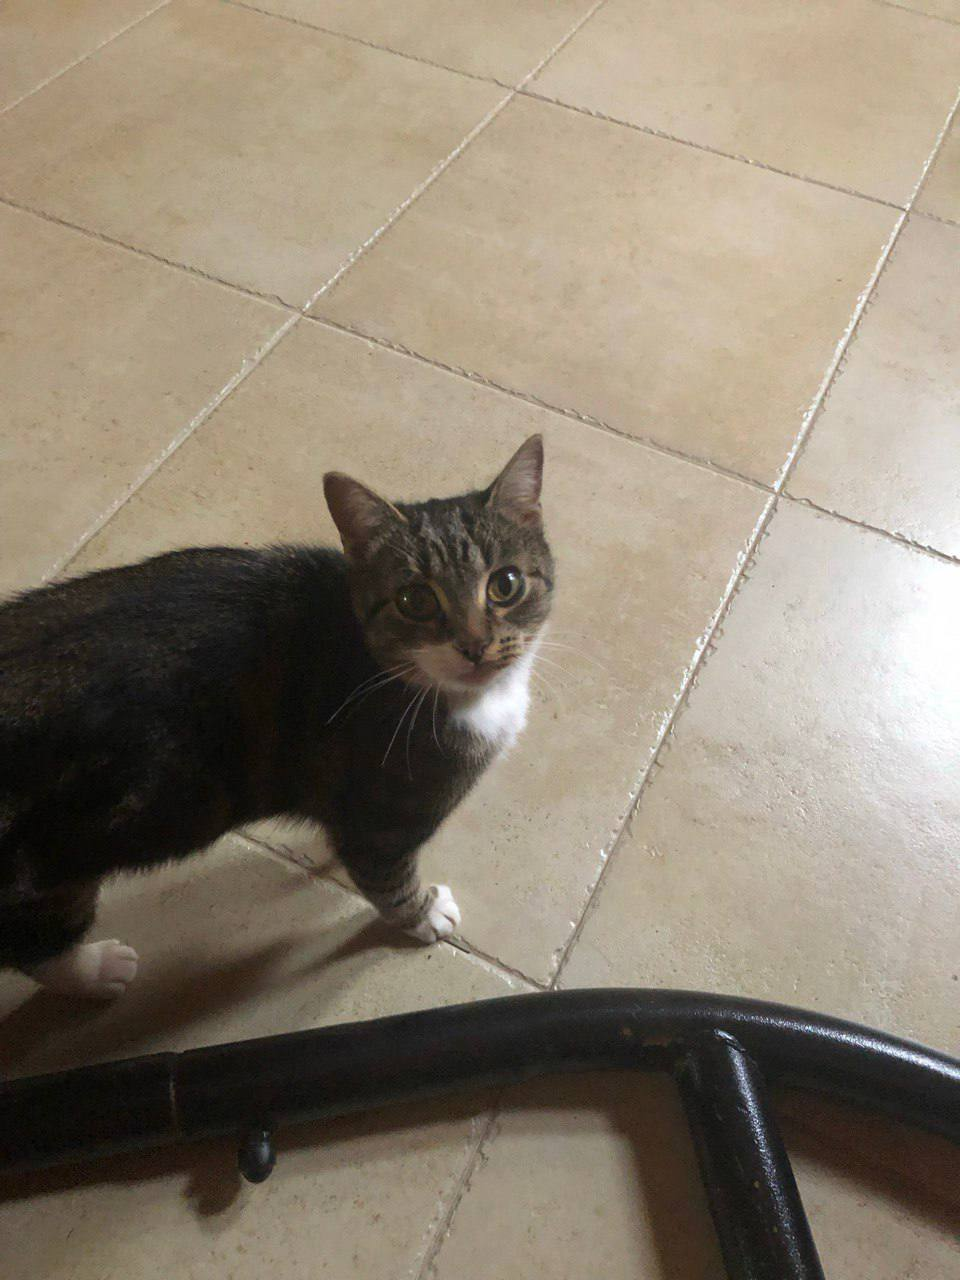